In [1]:
import numpy as np
import pandas as pd
import pickle
from pprint import pprint

# Gensim
import gensim
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import nltk; 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natalia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def read_data():
    western_df = pd.read_pickle('western_df_english_cleaned_final.pkl')
    non_western_df = pd.read_pickle('non_western_df_english_cleaned_final.pkl')
    western_df['type'] = 'western'
    non_western_df['type'] = 'non western'
    return pd.concat([western_df, non_western_df]).reset_index()

In [4]:
data = read_data()

In [5]:
data.shape

(3703201, 21)

In [6]:
data.head()

,index,id,date,comments,host_id,host_since,neighbourhood_cleansed,city,latitude,longitude,...,first_review,last_review,review_scores_rating,probability,language,comments_cleaned,comments_cleaned_sentiment,num_words,year,type
0,0,13913,2010-08-18,My girlfriend and I hadn't known Alina before ...,54730,2009-11-16,Islington,London,51.56802,-0.11121,...,2010-08-18,2020-02-22,97.0,0.999997,en,My girlfriend and I hadn t known Alina before ...,My girlfriend and I hadn t known Alina before ...,153,2010,western
1,1,13913,2011-07-11,Alina was a really good host. The flat is clea...,54730,2009-11-16,Islington,London,51.56802,-0.11121,...,2010-08-18,2020-02-22,97.0,0.999997,en,Alina was a really good host The flat is clean...,Alina was a really good host. The flat is clea...,31,2011,western
2,2,13913,2011-09-13,Alina is an amazing host. She made me feel rig...,54730,2009-11-16,Islington,London,51.56802,-0.11121,...,2010-08-18,2020-02-22,97.0,0.999995,en,Alina is an amazing host She made me feel righ...,Alina is an amazing host. She made me feel rig...,70,2011,western
3,3,13913,2011-10-03,"Alina's place is so nice, the room is big and ...",54730,2009-11-16,Islington,London,51.56802,-0.11121,...,2010-08-18,2020-02-22,97.0,0.999997,en,Alina s place is so nice the room is big and c...,Alina s place is so nice the room is big and c...,87,2011,western
4,4,13913,2011-10-09,"Nice location in Islington area, good for shor...",54730,2009-11-16,Islington,London,51.56802,-0.11121,...,2010-08-18,2020-02-22,97.0,0.999998,en,Nice location in Islington area good for short...,Nice location in Islington area good for short...,17,2011,western


In [7]:
print('The average number of words in a document is: {}'.format(round(data.num_words.mean())))
print('The minimum number of words in a document is: {}'.format(min(data.num_words)))
print('The maximum number of words in a document is: {}'.format(max(data.num_words)))

The average number of words in a document is: 49
The minimum number of words in a document is: 7
The maximum number of words in a document is: 263


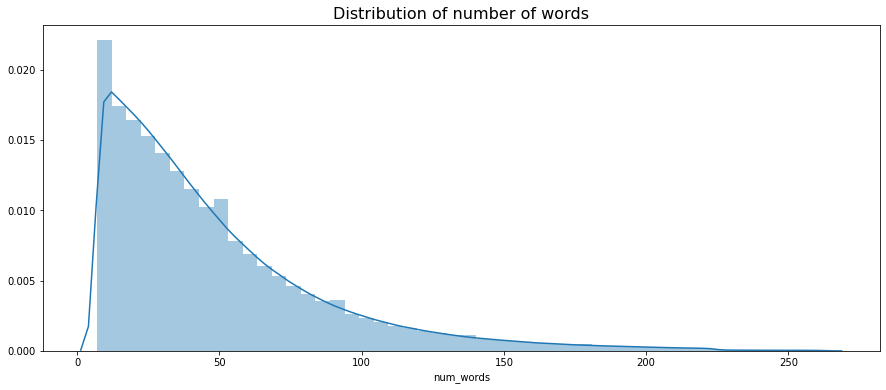

In [8]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(data.num_words, bins=50, ax=ax);

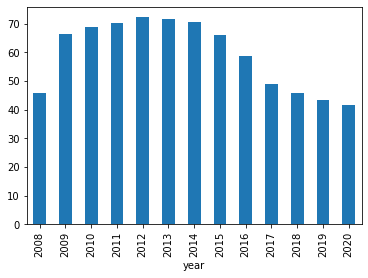

In [9]:
data.groupby(['year'])['num_words'].mean().plot(kind='bar');

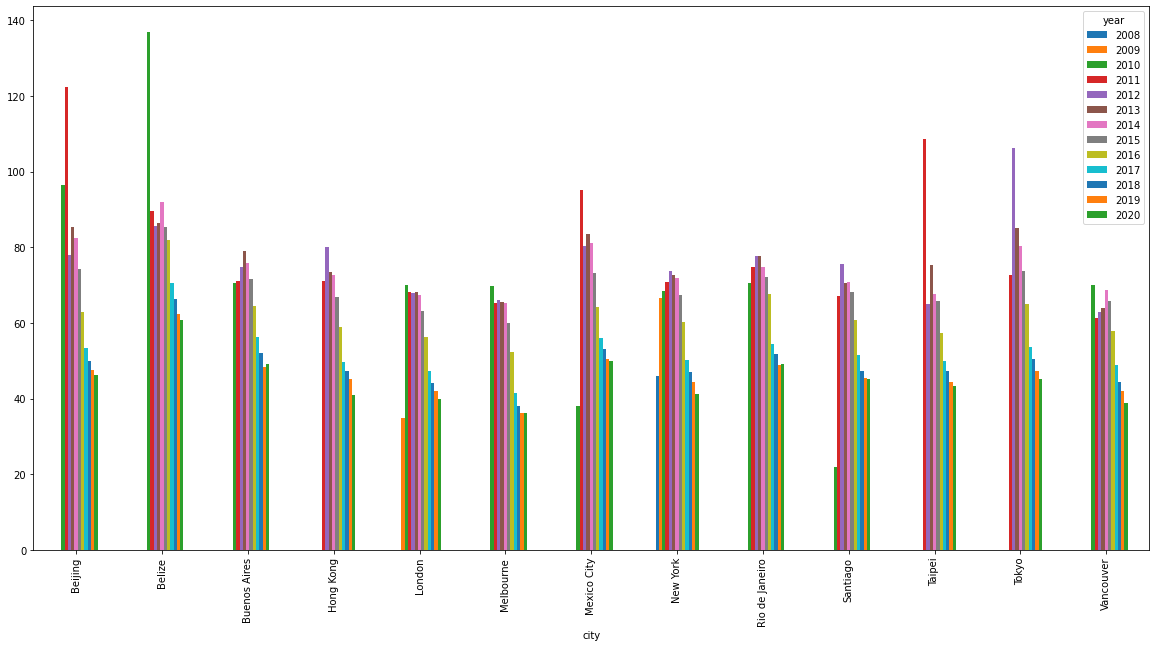

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
ax = data.groupby(['city', 'year'])['num_words'].mean().reset_index().pivot('city', 'year', 'num_words').plot(kind='bar', ax=ax);

In [13]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [16]:
data = stratified_sample_df(data, 'city', 50000)

In [18]:
data.shape

(283699, 21)

In [19]:
content = data.comments_cleaned.values.tolist()

In [22]:
pprint(content[:10])

['He greeted us with the upmost respect gave us privacy and gave directions on '
 'how to get places Our stay was beyond perfect and would definitely recommend '
 'his guesthouse And the inside oh my gosh AMAZING Sparkling clean like no one '
 'had ever stayed there before Thank you ',
 'This was a fantastic apartment that I would highly recommend The location '
 'was great being in the hutongs and very close to Guloudajie metro There were '
 'lots of options for food nearby and it was close to the Drum and Bell Towers '
 'The communication with the hosts was very good and they were available to '
 'provide advice throughout our trip It was incredibly useful being collected '
 'from the train station and this was included in the cost The host also kept '
 'our bags and brought these to the station for a small fee on our return trip '
 'The apartment itself was very comfortable with lots of modern amenities The '
 'beds were large and comfortable I would definitely recommend this apartm

In [23]:
all_words = ' '.join([text for text in content])
all_words = all_words.split()
all_words

['He',
 'greeted',
 'us',
 'with',
 'the',
 'upmost',
 'respect',
 'gave',
 'us',
 'privacy',
 'and',
 'gave',
 'directions',
 'on',
 'how',
 'to',
 'get',
 'places',
 'Our',
 'stay',
 'was',
 'beyond',
 'perfect',
 'and',
 'would',
 'definitely',
 'recommend',
 'his',
 'guesthouse',
 'And',
 'the',
 'inside',
 'oh',
 'my',
 'gosh',
 'AMAZING',
 'Sparkling',
 'clean',
 'like',
 'no',
 'one',
 'had',
 'ever',
 'stayed',
 'there',
 'before',
 'Thank',
 'you',
 'This',
 'was',
 'a',
 'fantastic',
 'apartment',
 'that',
 'I',
 'would',
 'highly',
 'recommend',
 'The',
 'location',
 'was',
 'great',
 'being',
 'in',
 'the',
 'hutongs',
 'and',
 'very',
 'close',
 'to',
 'Guloudajie',
 'metro',
 'There',
 'were',
 'lots',
 'of',
 'options',
 'for',
 'food',
 'nearby',
 'and',
 'it',
 'was',
 'close',
 'to',
 'the',
 'Drum',
 'and',
 'Bell',
 'Towers',
 'The',
 'communication',
 'with',
 'the',
 'hosts',
 'was',
 'very',
 'good',
 'and',
 'they',
 'were',
 'available',
 'to',
 'provide',
 'ad

In [10]:
from nltk import FreqDist
# function to plot most frequent terms
def freq_words(content, terms = 20):
    all_words = ' '.join([text for text in content])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns='count', n = terms) 
    plt.figure(figsize=(20,7))
    plt.tick_params(labelsize=12)
    ax = sns.barplot(data=d, x= 'word', y = 'count')
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xlabel('Word', fontsize=14)
    plt.title('Most frequent words', fontdict=dict(size=20))
    plt.show()

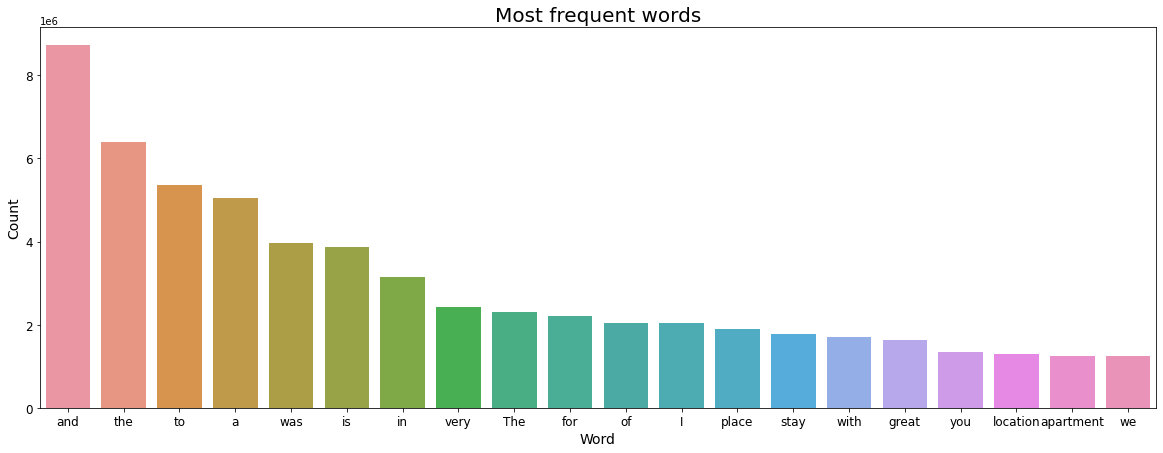

In [15]:
freq_words(content, 20)

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(content))

print(data_words[:1])

[['my', 'girlfriend', 'and', 'hadn', 'known', 'alina', 'before', 'we', 'took', 'the', 'leap', 'of', 'faith', 'to', 'rent', 'her', 'flat', 'alina', 'just', 'couldn', 'be', 'nicer', 'her', 'flat', 'is', 'comfortable', 'homey', 'very', 'sunny', 'and', 'quiet', 'at', 'night', 'her', 'diverse', 'neighborhood', 'rocks', 'it', 'full', 'of', 'excellent', 'eateries', 'of', 'varying', 'ethnicities', 'good', 'supermarkets', 'etc', 'etc', 'her', 'place', 'is', 'about', 'minute', 'walk', 'to', 'the', 'finsbury', 'park', 'tube', 'stop', 'and', 'there', 'are', 'also', 'several', 'buses', 'that', 'ply', 'stroud', 'green', 'road', 'the', 'piccadilly', 'and', 'victoria', 'tube', 'lines', 'that', 'serve', 'finsbury', 'park', 'are', 'very', 'dependable', 'and', 'come', 'frequently', 'my', 'only', 'caveat', 'is', 'if', 'you', 'are', 'unwilling', 'to', 'take', 'to', 'minute', 'commutes', 'to', 'downtown', 'london', 'attractions', 'and', 'money', 'is', 'no', 'object', 'you', 'will', 'prefer', 'to', 'stay', '

In [17]:
import pickle
with open('data_words.pkl', 'wb') as f:
    pickle.dump(data_words, f)

In [11]:
with open('data_words.pkl', 'rb') as f:
    data_words = pickle.load(f)

In [ ]:
import multiprocessing as mp

def sentence_to_words(sentence):
    return gensim.utils.simple_preprocess(str(sentence), deacc=True)

def sentences_to_words(sentences):
    pool = mp.Pool(mp.cpu_count() - 1)
    results = pool.map(sentence_to_words, [sentence for sentence in sentences])
    pool.close()    
    return results

data_words = list(sentences_to_words(content))

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[data_words[0]])

['my', 'girlfriend', 'and', 'hadn', 'known', 'alina', 'before', 'we', 'took', 'the', 'leap', 'of', 'faith', 'to', 'rent', 'her', 'flat', 'alina', 'just', 'couldn', 'be', 'nicer', 'her', 'flat', 'is', 'comfortable', 'homey', 'very', 'sunny', 'and', 'quiet', 'at', 'night', 'her', 'diverse', 'neighborhood', 'rocks', 'it', 'full', 'of', 'excellent', 'eateries', 'of', 'varying', 'ethnicities', 'good', 'supermarkets', 'etc', 'etc', 'her', 'place', 'is', 'about', 'minute', 'walk', 'to', 'the', 'finsbury', 'park', 'tube', 'stop', 'and', 'there', 'are', 'also', 'several', 'buses', 'that', 'ply', 'stroud_green', 'road', 'the', 'piccadilly', 'and', 'victoria', 'tube', 'lines', 'that', 'serve', 'finsbury', 'park', 'are', 'very', 'dependable', 'and', 'come', 'frequently', 'my', 'only', 'caveat', 'is', 'if', 'you', 'are', 'unwilling', 'to', 'take', 'to', 'minute', 'commutes', 'to', 'downtown', 'london', 'attractions', 'and', 'money', 'is', 'no', 'object', 'you', 'will', 'prefer', 'to', 'stay', 'down

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#def remove_stopwords(texts):
    #pool = mp.Pool(mp.cpu_count() - 1)
    #results = pool.map(remove_stopwords_from_text, [doc for doc in texts])
    #pool.close() 
    #return results
    #return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
    #return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return texts_out

In [26]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops[:1])

[['girlfriend', 'known', 'alina', 'took', 'leap', 'faith', 'rent', 'flat', 'alina', 'nicer', 'flat', 'comfortable', 'homey', 'sunny', 'quiet', 'night', 'diverse', 'neighborhood', 'rocks', 'full', 'excellent', 'eateries', 'varying', 'ethnicities', 'good', 'supermarkets', 'etc', 'etc', 'place', 'minute', 'walk', 'finsbury', 'park', 'tube', 'stop', 'also', 'several', 'buses', 'ply', 'stroud', 'green', 'road', 'piccadilly', 'victoria', 'tube', 'lines', 'serve', 'finsbury', 'park', 'dependable', 'come', 'frequently', 'caveat', 'unwilling', 'take', 'minute', 'commutes', 'downtown', 'london', 'attractions', 'money', 'object', 'prefer', 'stay', 'downtown', 'anyone', 'else', 'love', 'experience', 'living', 'real', 'untouristy', 'neighborhood', 'dealing', 'generous', 'warm', 'hearted', 'woman', 'happy', 'call', 'new', 'friend']]


In [27]:
with open('data_words_nostops.pkl', 'wb') as f:
    pickle.dump(data_words_nostops, f)

In [14]:
with open('data_words_nostops.pkl', 'rb') as f:
    data_words_nostops = pickle.load(f)

In [15]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[:1])

[['girlfriend', 'known', 'alina', 'took', 'leap', 'faith', 'rent', 'flat', 'alina', 'nicer', 'flat', 'comfortable', 'homey', 'sunny', 'quiet', 'night', 'diverse', 'neighborhood', 'rocks', 'full', 'excellent', 'eateries', 'varying', 'ethnicities', 'good', 'supermarkets', 'etc', 'etc', 'place', 'minute', 'walk', 'finsbury', 'park', 'tube', 'stop', 'also', 'several', 'buses', 'ply', 'stroud_green', 'road', 'piccadilly', 'victoria', 'tube', 'lines', 'serve', 'finsbury', 'park', 'dependable', 'come', 'frequently', 'caveat', 'unwilling', 'take', 'minute', 'commutes', 'downtown', 'london', 'attractions', 'money', 'object', 'prefer', 'stay', 'downtown', 'anyone', 'else', 'love', 'experience', 'living', 'real', 'untouristy', 'neighborhood', 'dealing', 'generous', 'warm', 'hearted', 'woman', 'happy', 'call', 'new', 'friend']]


In [16]:
with open('data_words_bigrams.pkl', 'wb') as f:
    pickle.dump(data_words_bigrams, f)

In [3]:
with open('data_words_bigrams.pkl', 'rb') as f:
    data_words_bigrams = pickle.load(f)

In [7]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['know', 'take', 'flat', 'nice', 'flat', 'comfortable', 'sunny', 'quiet', 'night', 'diverse', 'neighborhood', 'rock', 'full', 'excellent', 'eatery', 'vary', 'ethnicity', 'good', 'supermarket', 'place', 'minute', 'tube', 'stop', 'also', 'several', 'bus', 'ply', 'road', 'piccadilly', 'tube', 'line', 'serve', 'finsbury', 'park', 'dependable', 'come', 'frequently', 'caveat', 'unwilling', 'take', 'minute', 'commute', 'downtown', 'money', 'object', 'prefer', 'stay', 'downtown', 'else', 'love', 'experience', 'live', 'real', 'untouristy', 'neighborhood', 'deal', 'generous', 'warm', 'hearted', 'woman', 'happy', 'call', 'new', 'friend']]


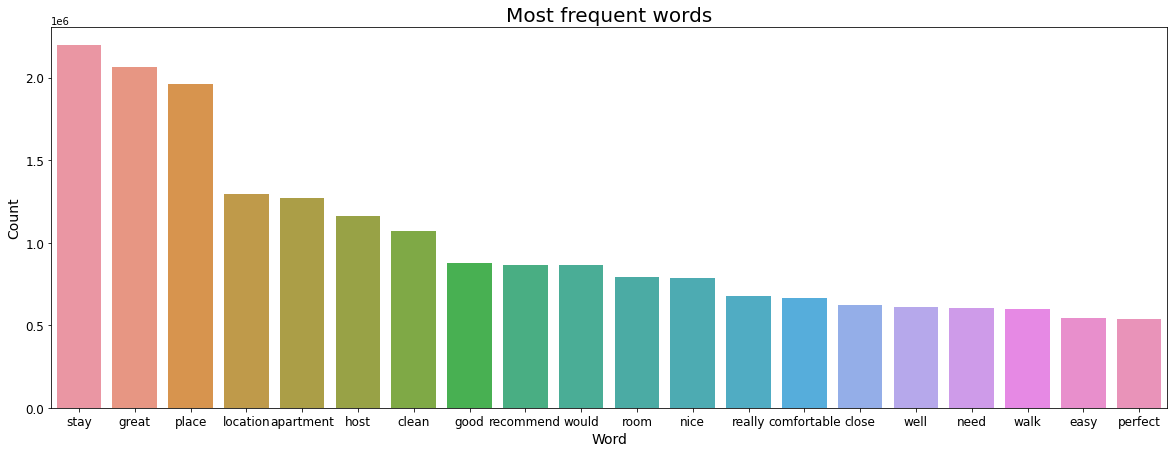

In [11]:
data = []
for i in range(len(data_lemmatized)):
    data.append(' '.join(data_lemmatized[i]))

freq_words(data, 20)

In [9]:
with open('data_lemmatized.pkl', 'wb') as f:
    pickle.dump(data_lemmatized, f)

In [4]:
with open('data_lemmatized.pkl', 'rb') as f:
    data_lemmatized = pickle.load(f)

In [10]:
words_freq = dict()
for doc in data_lemmatized:
    for word in doc:
        if word in words_freq:
            words_freq[word] = words_freq[word] + 1
        else:
            words_freq[word] = 1

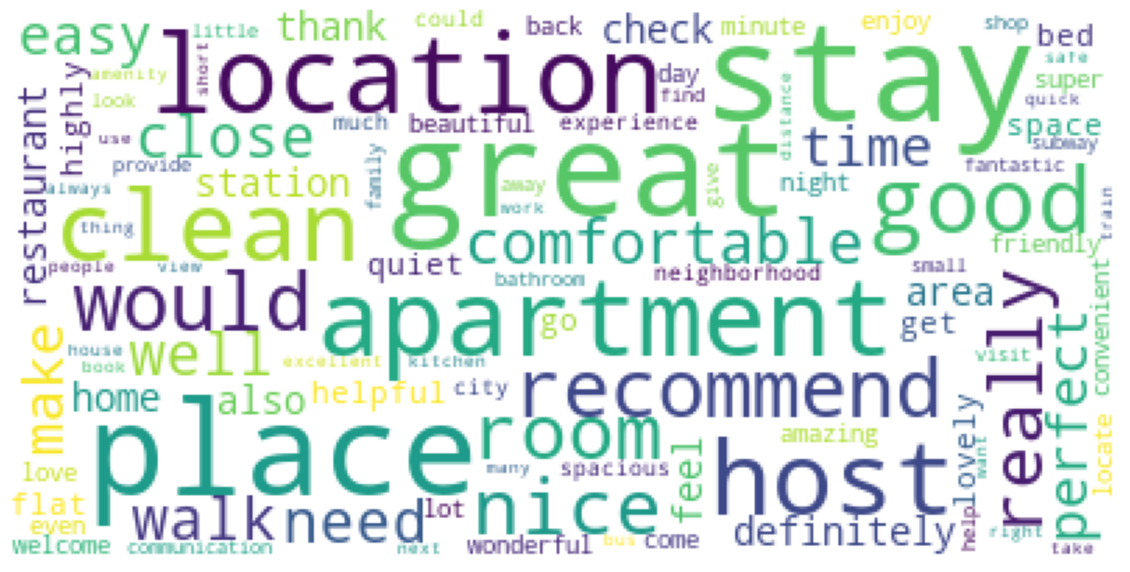

In [14]:
#Word cloud
from wordcloud import WordCloud, ImageColorGenerator

#words = ''
#for doc in data_lemmatized:
    #words = words + ' ' + ' '.join([text for text in doc])
    
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=50,
                      random_state=42).generate_from_frequencies(words_freq)
#print(wordcloud)
fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()